### Propensity-Score Matching

In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
import pandas as pd
import numpy as np
import torch

In [102]:
from pymatch.Matcher import Matcher

In [103]:
import os
os.chdir('/home/aisinai/work/repos/nis_patient_encoding/')

In [104]:
from data.data_loader import NISDatabase
from data.cohort_builder import CohortBuilder

from utils.experiments import *
from utils.feature_utils import calc_output_dims
from utils.code_mappings import *

from model.autoencoder.autoencoder import AutoEncoder
from model.autoencoder.loss import CustomLoss
from trainer.trainer import Trainer

In [105]:
DATA_FOLDER = 'data/raw/'
device = 'cuda:0'

In [106]:
case_db = NISDatabase(DATA_FOLDER + 'NIS_2012_2014_proto_emb_v2.h5', 'TRAIN', {})
control_db = NISDatabase(DATA_FOLDER + 'NIS_2012_2014_proto_emb_v2.h5', 'TRAIN', {})

DATA_FOLDER = 'data/raw/'
INPUT_FEATURES = {
    'AGE' : {'type': 'one_hot', 'rep_func': None},
    'FEMALE' : {'type': 'one-hot', 'rep_func': None},
    'HCUP_ED' : {'type': 'one-hot', 'rep_func': None},
    'TRAN_IN' : {'type': 'one-hot', 'rep_func': None},
    'ELECTIVE' : {'type': 'one-hot', 'rep_func': None},
    'ZIPINC_QRTL' : {'type': 'one-hot', 'rep_func': None},
    'DXn' : {'type': 'embedding', 'rep_func': None},
    'ECODEn' : {'type': 'embedding', 'rep_func': None},
    'PRn' : {'type': 'embedding', 'rep_func': None},
    'CHRONn' : {'type': 'embedding', 'rep_func': None},
}

DEFAULT_BUILD = {
    'encoding' : {
        'total_layers' : 1,
        'scale' : 4,
        'activation' : 'leaky_relu',
    },

    'latent' : {'dimensions' : 64},

    'decoding' : {
        'scale' : 4,
        'activation' : 'leaky_relu',
        'total_layers' : 1,
        'output_dims' : None
    }
}

EMBEDDING_DICTIONARY = {

     'CHRONn' : {
        'header_prefix' : b'CHRON',
        'num_classes' : 12583,
        'dimensions' : 256,
    },   

    'DXn' : {
        'header_prefix' : b'DX',
        'num_classes' : 12583,
        'dimensions' : 256,
    },

    'PRn' : {
        'header_prefix' : b'PR',
        'num_classes' : 4445,
        'dimensions' : 64,
    },

    'ECODEn' : {
        'header_prefix' : b'ECODE',
        'num_classes' : 1186,
        'dimensions' : 32,
    },

    'CHRONBn' : {
        'header_prefix' : b'CHRONB',
        'num_classes' : 19,
        'dimensions' : 16,
    }
}

ONE_HOT_LIST = [b'ELECTIVE', b'FEMALE', b'HCUP_ED', b'TRAN_IN', b'ZIPINC_QRTL', b'AGE']
ONE_HOTS = { feature.decode('utf-8') : {} for feature in ONE_HOT_LIST }
ONE_HOTS['ELECTIVE']['num_classes'] = 2 # 0,1
ONE_HOTS['FEMALE']['num_classes'] = 2 # 0,1
ONE_HOTS['TRAN_IN']['num_classes'] = 3 # 0-2
ONE_HOTS['HCUP_ED']['num_classes'] = 5 # 0-4
ONE_HOTS['ZIPINC_QRTL']['num_classes'] = 5 # 1-4
ONE_HOTS['AGE']['num_classes'] = 13 # 0-12 (must be allowed to guess in between as well)

CONTINUOUS = {}

FEATURE_REPRESENTATIONS = {}
FEATURE_REPRESENTATIONS['embedding'] = EMBEDDING_DICTIONARY
FEATURE_REPRESENTATIONS['one_hots'] = ONE_HOTS
FEATURE_REPRESENTATIONS['continuous'] = CONTINUOUS

DEFAULT_BUILD['features'] = FEATURE_REPRESENTATIONS

find_nlike_features(case_db.headers, FEATURE_REPRESENTATIONS['embedding'])
FEATURE_REPRESENTATIONS['one_hots'] = create_onehot_info(case_db, FEATURE_REPRESENTATIONS['one_hots'], FEATURE_REPRESENTATIONS['embedding'])
DEFAULT_BUILD['features'] = FEATURE_REPRESENTATIONS
calc_output_dims(DEFAULT_BUILD)

In [107]:
ae = AutoEncoder(DEFAULT_BUILD)
# ae.load_state('/home/aisinai/work/repos/nis_patient_encoding/experiments/train_ae_020/1587303827.pth', device=device)

In [108]:
cc_stroke = tables.open_file(DATA_FOLDER + 'NIS_stroke_casecontrol_orig.h5', 'r')

case_data_psm = cc_stroke.root.cases_orig[:]
control_data_psm = cc_stroke.root.controls_orig[:]

In [109]:
headers = [b'AGE', b'CHRON01', b'CHRON02', b'CHRON03', b'CHRON04', b'CHRON05',
       b'CHRON06', b'CHRON07', b'CHRON08', b'CHRON09', b'CHRON10',
       b'CHRON11', b'CHRON12', b'CHRON13', b'CHRON14', b'CHRON15',
       b'CHRON16', b'CHRON17', b'CHRON18', b'CHRON19', b'CHRON20',
       b'CHRON21', b'CHRON22', b'CHRON23', b'CHRON24', b'CHRON25',
       b'CHRON26', b'CHRON27', b'CHRON28', b'CHRON29', b'CHRON30',
       b'CHRONB01', b'CHRONB02', b'CHRONB03', b'CHRONB04', b'CHRONB05',
       b'CHRONB06', b'CHRONB07', b'CHRONB08', b'CHRONB09', b'CHRONB10',
       b'CHRONB11', b'CHRONB12', b'CHRONB13', b'CHRONB14', b'CHRONB15',
       b'CHRONB16', b'CHRONB17', b'CHRONB18', b'CHRONB19', b'CHRONB20',
       b'CHRONB21', b'CHRONB22', b'CHRONB23', b'CHRONB24', b'CHRONB25',
       b'CHRONB26', b'CHRONB27', b'CHRONB28', b'CHRONB29', b'CHRONB30',
       b'DX01', b'DX02', b'DX03', b'DX04', b'DX05', b'DX06', b'DX07',
       b'DX08', b'DX09', b'DX10', b'DX11', b'DX12', b'DX13', b'DX14',
       b'DX15', b'DX16', b'DX17', b'DX18', b'DX19', b'DX20', b'DX21',
       b'DX22', b'DX23', b'DX24', b'DX25', b'DX26', b'DX27', b'DX28',
       b'DX29', b'DX30', b'ECODE01', b'ECODE02', b'ECODE03', b'ECODE04',
       b'ELECTIVE', b'FEMALE', b'HCUP_ED', b'PR01', b'PR02', b'PR03',
       b'PR04', b'PR05', b'PR06', b'PR07', b'PR08', b'PR09', b'PR10',
       b'PR11', b'PR12', b'PR13', b'PR14', b'PR15', b'TRAN_IN',
       b'ZIPINC_QRTL']

In [110]:
case_data_psm = pd.DataFrame(case_data_psm, columns=[header.decode('utf-8') for header in headers]).loc[:, ['AGE', 'FEMALE', 'HCUP_ED', 'ELECTIVE', 'TRAN_IN', 'ZIPINC_QRTL', 'CHRONB01']].astype('int')
case_data_psm['CHRONB01'] = 1

In [111]:
control_data_psm = pd.DataFrame(control_data_psm, columns=[header.decode('utf-8') for header in headers]).loc[:, ['AGE', 'FEMALE', 'HCUP_ED', 'ELECTIVE', 'TRAN_IN', 'ZIPINC_QRTL', 'CHRONB01']].astype('int')
control_data_psm['CHRONB01'] = 0

In [112]:
psm_matcher = Matcher(case_data_psm, control_data_psm, yvar='CHRONB01', exclude=[])

Formula:
CHRONB01 ~ AGE+FEMALE+HCUP_ED+ELECTIVE+TRAN_IN+ZIPINC_QRTL
n majority: 1782567
n minority: 12990


In [115]:
np.random.seed(0)
psm_matcher.fit_scores(balance=True, nmodels=20)

Fitting Models on Balanced Samples: 20\20
Average Accuracy: 58.67%


In [132]:
pwd

'/home/aisinai/work/repos/nis_patient_encoding'

In [133]:
psm_matcher.data.to_csv('data/raw/NIS_cc_stroke_psminput.csv')

In [116]:
psm_matcher.predict_scores()

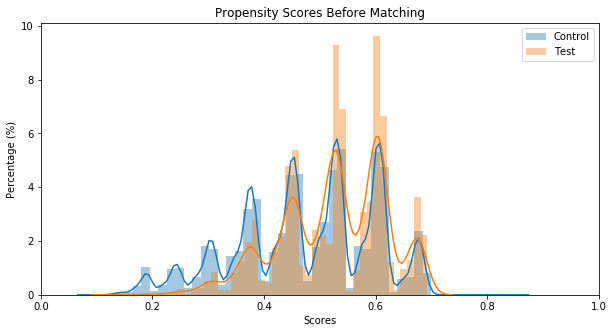

In [117]:
psm_matcher.plot_scores()

In [17]:
psm_matcher.tune_threshold(method='random')

KeyboardInterrupt: 

In [118]:
psm_matcher.match(method="random", nmatches=1, threshold=0.01)

In [119]:
psm_matcher.assign_weight_vector()

### Assess Performance

In [194]:
case_data_psm = pd.DataFrame(case_data_psm, columns=[header.decode('utf-8') for header in headers])
control_data_psm = pd.DataFrame(control_data_psm, columns=[header.decode('utf-8') for header in headers])

In [121]:
case_data_psm.shape

(12990, 115)

In [195]:
all_case_inds = np.load(DATA_FOLDER + 'NIS_caseindices.npy')
all_control_inds = np.load(DATA_FOLDER + 'NIS_controlindices.npy')

In [196]:
cases = np.array(psm_matcher.matched_data.loc[psm_matcher.matched_data['CHRONB01'] == 1, 'record_id'])
controls = np.array(psm_matcher.matched_data.loc[psm_matcher.matched_data['CHRONB01'] == 0, 'record_id']) - case_data_psm.shape[0]

In [197]:
cases_matched = psm_matcher.matched_data.loc[psm_matcher.matched_data['CHRONB01'] == 1, ['AGE', 'FEMALE', 'HCUP_ED', 'ELECTIVE', 'TRAN_IN', 'ZIPINC_QRTL']]
controls_matched = psm_matcher.matched_data.loc[psm_matcher.matched_data['CHRONB01'] == 0, ['AGE', 'FEMALE', 'HCUP_ED', 'ELECTIVE', 'TRAN_IN', 'ZIPINC_QRTL']]

In [198]:
case_inds = all_case_inds[cases]
control_inds = all_control_inds[controls]

case_db.set_inds(case_inds)
control_db.set_inds(control_inds)

case_dl = torch.utils.data.DataLoader(case_db, batch_size=1000, pin_memory=True, num_workers=4)
control_dl = torch.utils.data.DataLoader(control_db, batch_size=1000, pin_memory=True, num_workers=4)

In [199]:
case_data = {}

for idx, case_batch in enumerate(case_dl):
    target = ae.format_ground_truth(case_batch)
    
    for feature, recon in target.items():
        if feature not in list(case_data.keys()):
            recon_np = np.array(recon.detach().to('cpu'))
            case_data[feature] = recon_np
        else:
            recon_np = np.array(recon.detach().to('cpu'))
            case_data[feature] = np.vstack((case_data[feature], recon_np))

In [200]:
control_data = {}

for idx, control_batch in enumerate(control_dl):
    target = ae.format_ground_truth(control_batch)
    
    for feature, recon in target.items():
        if feature not in list(control_data.keys()):
            recon_np = np.array(recon.detach().to('cpu'))
            control_data[feature] = recon_np
        else:
            recon_np = np.array(recon.detach().to('cpu'))
            control_data[feature] = np.vstack((control_data[feature], recon_np))

In [201]:
from scipy.stats import chisquare
import pandas as pd

t_test_vals = pd.DataFrame(index=case_data.keys(), columns=['p_value', ])

t_tests = {}
for (_, case), (feature_name, control) in zip(case_data.items(), control_data.items()): 
#     if feature_name[-1] != 'n':
    t_tests[feature_name] = {}

    tfn = t_tests[feature_name] # shorthand
    
    # Find number of class representatives
    ft_0 = np.sum(control, axis=0)
    ft_1 = np.sum(case, axis=0)
    
    # Remove nonzero classes
    ft_nonzero = np.array([[ft_0i, ft_1i] for ft_0i, ft_1i in zip(ft_0, ft_1) if ft_1i != 0]).astype('int')

#     print(feature_name, (ft_nonzero[:, 0], ft_nonzero[:, 1]))
    t_tests[feature_name]['case_control'] = pd.DataFrame(np.vstack((ft_0, ft_1)).T, columns=['CONTROL', 'CASE']).rename_axis(feature_name)
    
    # Compute the chi-sq value and p-value
    tfn['chisq'], tfn['pval'] = chisquare(ft_nonzero[:, 0], ft_nonzero[:, 1])
    t_tests[feature_name]['p_value'] = tfn['pval']
    t_tests[feature_name]['chisq'] = tfn['chisq']
    t_test_vals.loc[feature_name, 'p_value'] =  tfn['pval']
    t_test_vals.loc[feature_name, 'chisq'] =  tfn['chisq']
    t_test_vals.loc[feature_name, 'type'] =  'cat'


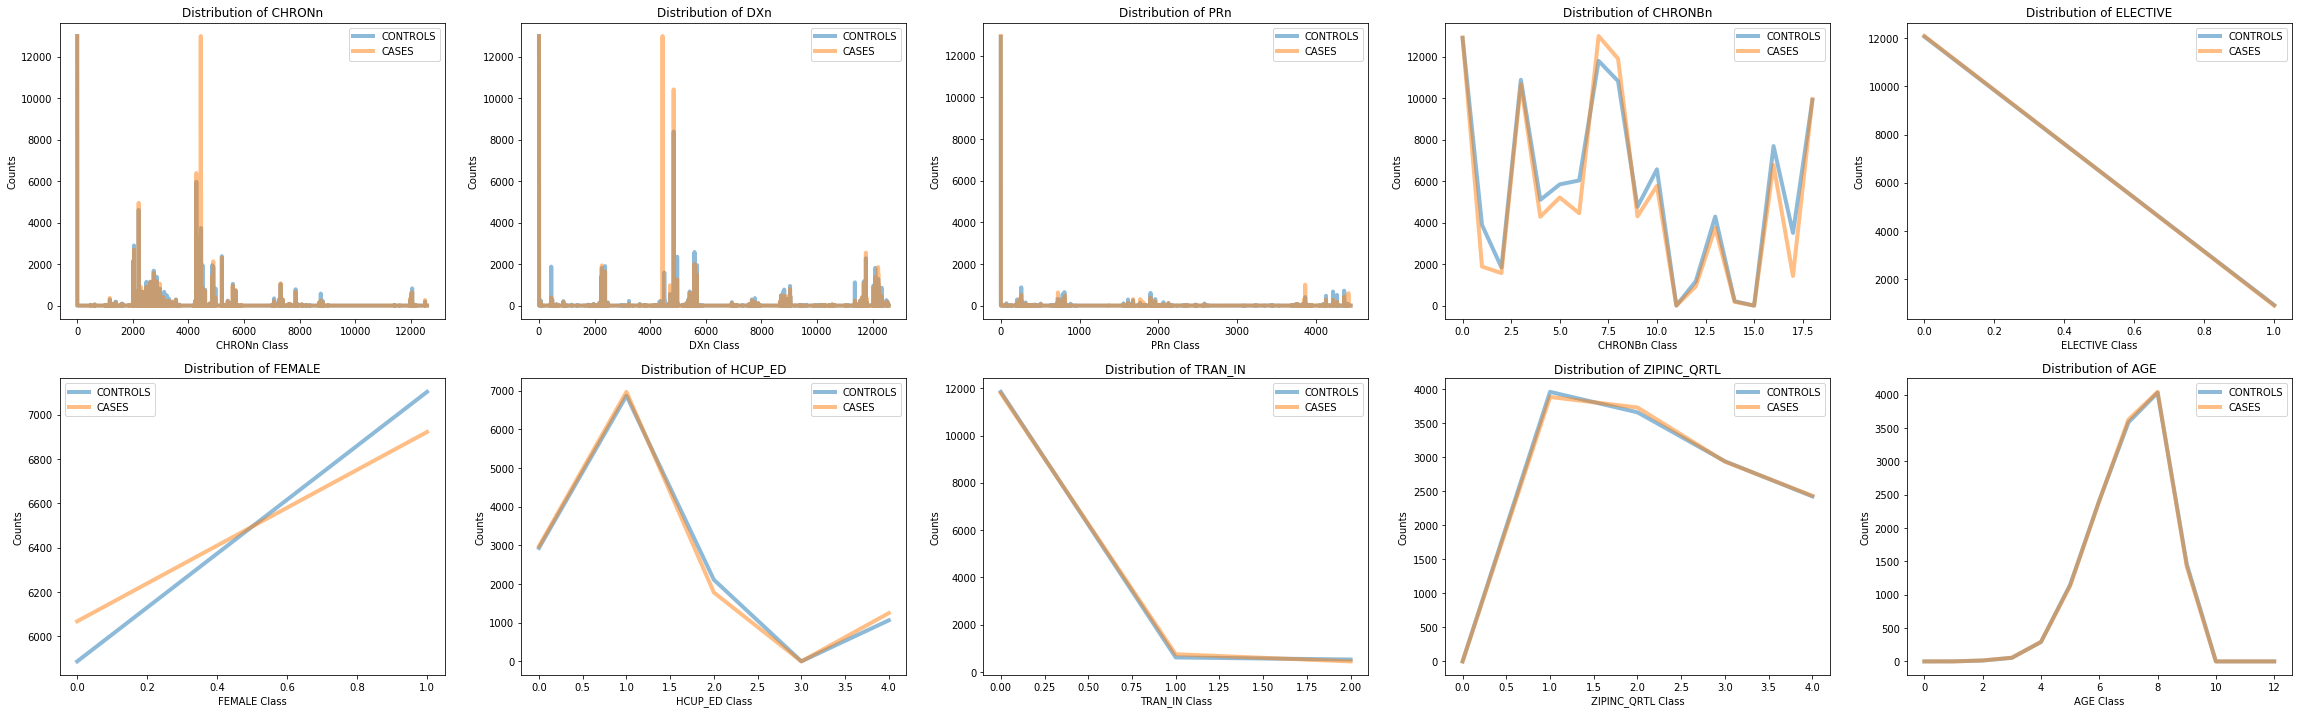

In [202]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 12))

count = 1
for feature_name in t_tests.keys():
    if feature_name != 'ECODEn':
        plt.subplot(2, 5, count)
        plt.plot(t_tests[feature_name]['case_control'], alpha=0.5, linewidth=4)
        plt.legend(['CONTROLS', 'CASES'])
        plt.xlabel("{0} Class".format(feature_name))
        plt.ylabel("Counts".format(feature_name))
        plt.title("Distribution of {0}".format(feature_name))
        count += 1

In [203]:
t_test_vals

,p_value,chisq,type
CHRONn,0,31402.182570,cat
DXn,0,53105.927222,cat
PRn,0,16307.475430,cat
ECODEn,2.13802e-132,1087.809710,cat
CHRONBn,0,6640.998312,cat
ELECTIVE,0.446469,0.579600,cat
FEMALE,0.00145728,10.131859,cat
HCUP_ED,3.22466e-19,92.875413,cat
TRAN_IN,3.73711e-09,38.809909,cat
ZIPINC_QRTL,0.418647,2.829624,cat


### Assess Performance - Match in R

In [120]:
case_data_psm = pd.DataFrame(case_data_psm, columns=[header.decode('utf-8') for header in headers])
control_data_psm = pd.DataFrame(control_data_psm, columns=[header.decode('utf-8') for header in headers])

In [121]:
case_data_psm.shape

(12990, 115)

In [183]:
cases = np.array(pd.read_csv(DATA_FOLDER + 'NIS_cc_caseinds_stroke_Rpsm.csv')['x'])
controls = np.array(pd.read_csv(DATA_FOLDER + 'NIS_cc_continds_stroke_Rpsm.csv')['x'])

In [167]:
controls.max()

1782372

In [168]:
controls

array([1441751,  228254, 1101904, ...,   57746,  388163,   43668])

In [185]:
case_inds = all_case_inds[cases]
control_inds = all_control_inds[controls]

case_db.set_inds(case_inds)
control_db.set_inds(control_inds)

case_dl = torch.utils.data.DataLoader(case_db, batch_size=1000, pin_memory=True, num_workers=4)
control_dl = torch.utils.data.DataLoader(control_db, batch_size=1000, pin_memory=True, num_workers=4)

In [186]:
control_db.inds, all_control_inds[controls]

(array([14210274,  2358365, 10950262, ...,   563930,  3991458,   421808]),
 array([14210274,  2358365, 10950262, ...,   563930,  3991458,   421808]))

In [170]:
case_data = {}

for idx, case_batch in enumerate(case_dl):
    target = ae.format_ground_truth(case_batch)
    
    for feature, recon in target.items():
        if feature not in list(case_data.keys()):
            recon_np = np.array(recon.detach().to('cpu'))
            case_data[feature] = recon_np
        else:
            recon_np = np.array(recon.detach().to('cpu'))
            case_data[feature] = np.vstack((case_data[feature], recon_np))

In [190]:
control_data = {}

for idx, control_batch in enumerate(control_dl):
    target = ae.format_ground_truth(control_batch)
    
    for feature, recon in target.items():
        if feature not in list(control_data.keys()):
            recon_np = np.array(recon.detach().to('cpu'))
            control_data[feature] = recon_np
        else:
            recon_np = np.array(recon.detach().to('cpu'))
            control_data[feature] = np.vstack((control_data[feature], recon_np))

In [191]:
from scipy.stats import chisquare
import pandas as pd

t_test_vals = pd.DataFrame(index=case_data.keys(), columns=['p_value', ])

t_tests = {}
for (_, case), (feature_name, control) in zip(case_data.items(), control_data.items()): 
#     if feature_name[-1] != 'n':
    t_tests[feature_name] = {}

    tfn = t_tests[feature_name] # shorthand
    
    # Find number of class representatives
    ft_0 = np.sum(control, axis=0)
    ft_1 = np.sum(case, axis=0)
    
    # Remove nonzero classes
    ft_nonzero = np.array([[ft_0i, ft_1i] for ft_0i, ft_1i in zip(ft_0, ft_1) if ft_1i != 0]).astype('int')

#     print(feature_name, (ft_nonzero[:, 0], ft_nonzero[:, 1]))
    t_tests[feature_name]['case_control'] = pd.DataFrame(np.vstack((ft_0, ft_1)).T, columns=['CONTROL', 'CASE']).rename_axis(feature_name)
    
    # Compute the chi-sq value and p-value
    tfn['chisq'], tfn['pval'] = chisquare(ft_nonzero[:, 0], ft_nonzero[:, 1])
    t_tests[feature_name]['p_value'] = tfn['pval']
    t_tests[feature_name]['chisq'] = tfn['chisq']
    t_test_vals.loc[feature_name, 'p_value'] =  tfn['pval']
    t_test_vals.loc[feature_name, 'chisq'] =  tfn['chisq']
    t_test_vals.loc[feature_name, 'type'] =  'cat'


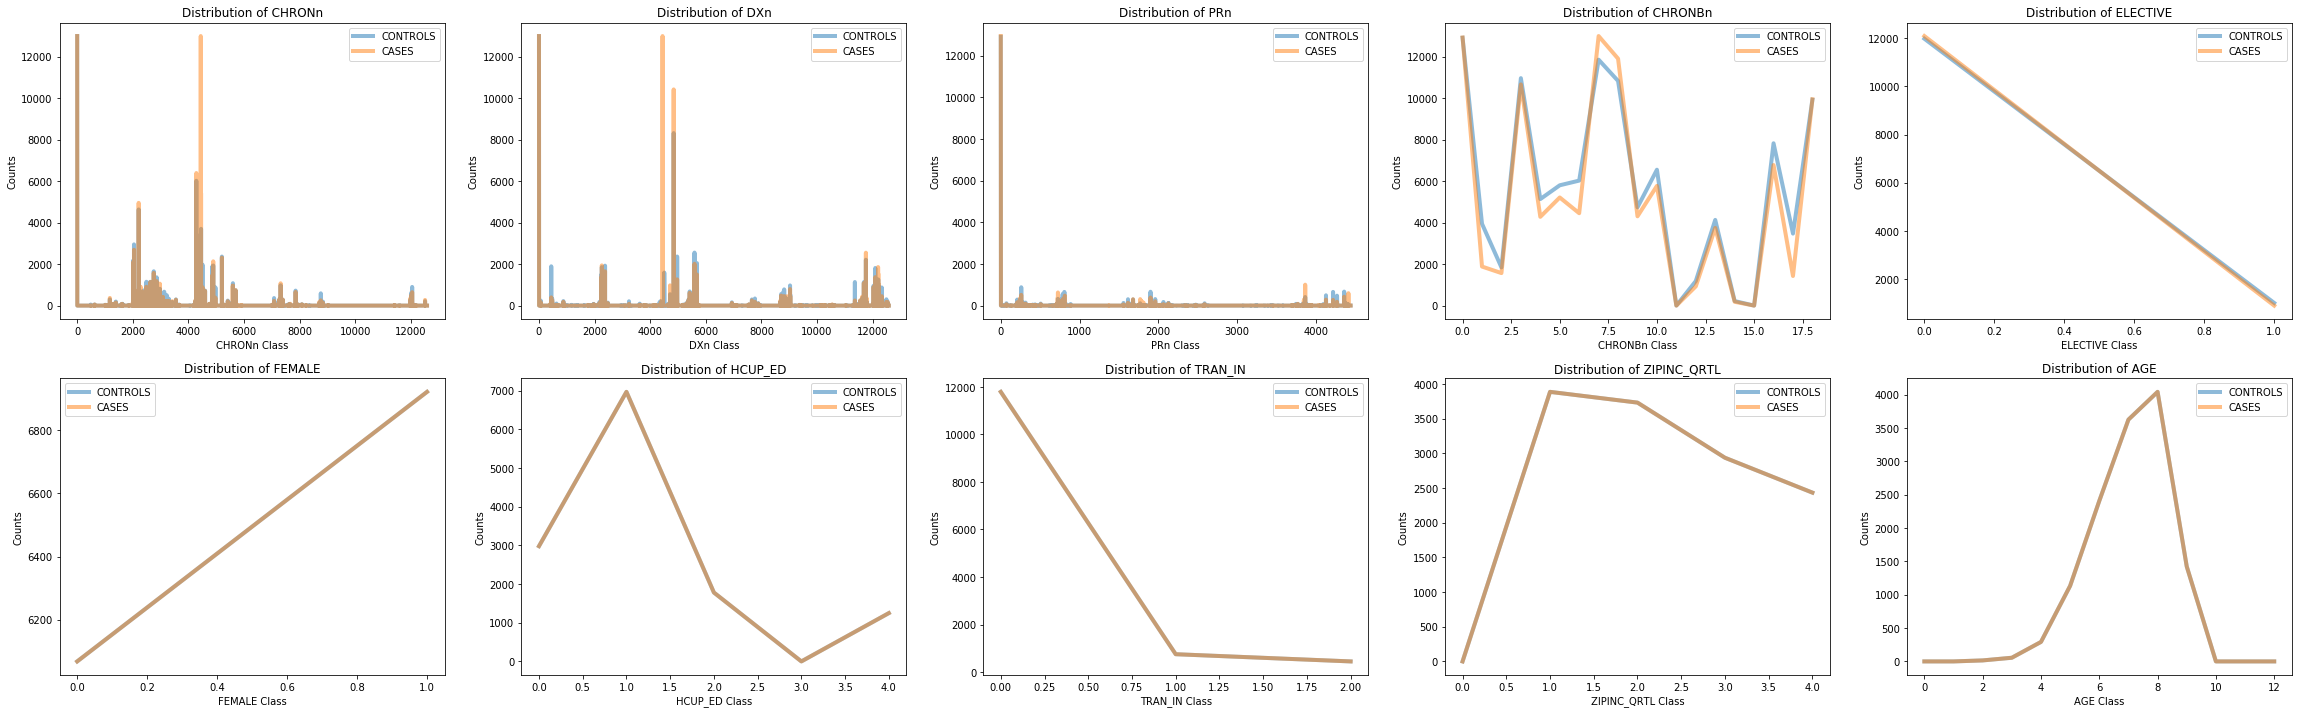

In [192]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 12))

count = 1
for feature_name in t_tests.keys():
    if feature_name != 'ECODEn':
        plt.subplot(2, 5, count)
        plt.plot(t_tests[feature_name]['case_control'], alpha=0.5, linewidth=4)
        plt.legend(['CONTROLS', 'CASES'])
        plt.xlabel("{0} Class".format(feature_name))
        plt.ylabel("Counts".format(feature_name))
        plt.title("Distribution of {0}".format(feature_name))
        count += 1

In [193]:
t_test_vals

,p_value,chisq,type
CHRONn,0,32068.220139,cat
DXn,0,54506.260914,cat
PRn,0,18887.189946,cat
ECODEn,2.4903e-141,1136.409339,cat
CHRONBn,0,6659.751323,cat
ELECTIVE,0.000122446,14.754640,cat
FEMALE,1,0.000000,cat
HCUP_ED,1,0.000000,cat
TRAN_IN,1,0.000000,cat
ZIPINC_QRTL,1,0.000000,cat


### Convert to Latent Space

In [63]:
ae.load_state('/home/aisinai/work/repos/nis_patient_encoding/experiments/train_ae_020/1587303827.pth', device=device)
ae = ae.to(device)

In [93]:
import tables
cc_stroke = tables.open_file(DATA_FOLDER + 'NIS_stroke_casecontrol_orig.h5', 'r')

In [99]:
cc_stroke.close()

In [94]:
unique, counts = np.unique(controls, return_counts=True)
controls_unique = unique[counts == 1]

In [95]:
cc_stroke.root.controls.shape[0], controls.max(), control_data_psm.shape[0]

(1765170, 1782547, 1782567)

In [87]:
cases_ls = cc_stroke.root.cases[cases, :]
controls_ls = cc_stroke.root.controls[controls_unique, :]

IndexError: Index out of bounds: 1765463

In [50]:
case_data = {}

for idx, case_batch in enumerate(case_dl):
    case_batch = case_batch.to(device)
    cc_stroke.root.cases.append(np.array(ae.latent_representation(case_batch.to(device)).detach().to('cpu')))    
    
    for feature, recon in target.items():
        if feature not in list(case_data.keys()):
            recon_np = np.array(recon.detach().to('cpu'))
            case_data[feature] = recon_np
        else:
            recon_np = np.array(recon.detach().to('cpu'))
            case_data[feature] = np.vstack((case_data[feature], recon_np))

In [52]:
control_data = {}

for idx, control_batch in enumerate(control_dl):
    target = ae.format_ground_truth(case_batch)
    
    for feature, recon in target.items():
        if feature not in list(control_data.keys()):
            recon_np = np.array(recon.detach().to('cpu'))
            control_data[feature] = recon_np
        else:
            recon_np = np.array(recon.detach().to('cpu'))
            control_data[feature] = np.vstack((control_data[feature], recon_np))